In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import geopandas as gpd
import contextily as ctx
from shapely.geometry import Point

from datetime import datetime

pd.set_option("display.max_column", 100)

/Users/jasonzhang/Documents/PersonalProjects/SafeStride/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


# Data Cleaning

In [2]:
crime_df = pd.read_csv("../data/crime_2022.csv")
crime_df

/var/folders/q0/tp61rdx579s1pr09fjqsx_gw0000gn/T/ipykernel_2634/1756663924.py:1: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  crime_df = pd.read_csv("../data/crime_2022.csv")


,INCIDENT_NUMBER,OFFENSE_CODE,OFFENSE_CODE_GROUP,OFFENSE_DESCRIPTION,DISTRICT,REPORTING_AREA,SHOOTING,OCCURRED_ON_DATE,YEAR,MONTH,DAY_OF_WEEK,HOUR,UCR_PART,STREET,Lat,Long,Location
0,222076257,619,NaN,LARCENY ALL OTHERS,D4,167,0,2022-01-01 00:00:00,2022,1,Saturday,0,NaN,HARRISON AVE,42.339542,-71.069409,"(42.33954198983014, -71.06940876967543)"
1,222053099,2670,NaN,HARASSMENT/ CRIMINAL HARASSMENT,A7,,0,2022-01-01 00:00:00,2022,1,Saturday,0,NaN,BENNINGTON ST,42.377246,-71.032597,"(42.37724638479816, -71.0325970804128)"
2,222039411,3201,NaN,PROPERTY - LOST/ MISSING,D14,778,0,2022-01-01 00:00:00,2022,1,Saturday,0,NaN,WASHINGTON ST,42.349056,-71.150498,"(42.34905600030506, -71.15049849975023)"
3,222011090,3201,NaN,PROPERTY - LOST/ MISSING,B3,465,0,2022-01-01 00:00:00,2022,1,Saturday,0,NaN,BLUE HILL AVE,42.284826,-71.091374,"(42.28482576580488, -71.09137368938802)"
4,222062685,3201,NaN,PROPERTY - LOST/ MISSING,B3,465,0,2022-01-01 00:00:00,2022,1,Saturday,0,NaN,BLUE HILL AVE,42.284826,-71.091374,"(42.28482576580488, -71.09137368938802)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73847,232000091,1402,NaN,VANDALISM,A1,66,0,2022-12-31 23:30:00,2022,12,Saturday,23,NaN,CHARLES ST,42.359790,-71.070782,"(42.35979037458775, -71.07078234449541)"
73848,232000002,3831,NaN,M/V - LEAVING SCENE - PROPERTY DAMAGE,C11,,0,2022-12-31 23:37:00,2022,12,Saturday,23,NaN,COLUMBIA RD,42.319593,-71.062607,"(42.31959298334654, -71.06260699634272)"
73849,232000140,619,NaN,LARCENY ALL OTHERS,D14,778,0,2022-12-31 23:45:00,2022,12,Saturday,23,NaN,WASHINGTON ST,42.349056,-71.150498,"(42.34905600030506, -71.15049849975023)"
73850,232000315,3201,NaN,PROPERTY - LOST/ MISSING,D4,167,0,2022-12-31 23:50:00,2022,12,Saturday,23,NaN,HARRISON AVENUE,NaN,NaN,NaN


In [3]:
crime_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73852 entries, 0 to 73851
Data columns (total 17 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   INCIDENT_NUMBER      73852 non-null  object 
 1   OFFENSE_CODE         73852 non-null  int64  
 2   OFFENSE_CODE_GROUP   0 non-null      float64
 3   OFFENSE_DESCRIPTION  73852 non-null  object 
 4   DISTRICT             73681 non-null  object 
 5   REPORTING_AREA       73852 non-null  object 
 6   SHOOTING             73852 non-null  int64  
 7   OCCURRED_ON_DATE     73852 non-null  object 
 8   YEAR                 73852 non-null  int64  
 9   MONTH                73852 non-null  int64  
 10  DAY_OF_WEEK          73852 non-null  object 
 11  HOUR                 73852 non-null  int64  
 12  UCR_PART             0 non-null      float64
 13  STREET               73851 non-null  object 
 14  Lat                  70044 non-null  float64
 15  Long                 70044 non-null 

## Initial observations
1. OFFENSE_CODE_GROUP and UCR_PART are completely null, thus we can drop
2. INCIDENT_NUMBER can be cast into int type (unless some start with a 0)
3. OCCURRED_ON_DATE and other time columns can be cast into datetime

In [4]:
# Drop null and redundant columns
crime_df = crime_df.drop(columns=["OFFENSE_CODE_GROUP", "UCR_PART", "YEAR", "MONTH", "HOUR"])
crime_df["OCCURRED_ON_DATE"] = pd.to_datetime(crime_df["OCCURRED_ON_DATE"])
crime_df

,INCIDENT_NUMBER,OFFENSE_CODE,OFFENSE_DESCRIPTION,DISTRICT,REPORTING_AREA,SHOOTING,OCCURRED_ON_DATE,DAY_OF_WEEK,STREET,Lat,Long,Location
0,222076257,619,LARCENY ALL OTHERS,D4,167,0,2022-01-01 00:00:00,Saturday,HARRISON AVE,42.339542,-71.069409,"(42.33954198983014, -71.06940876967543)"
1,222053099,2670,HARASSMENT/ CRIMINAL HARASSMENT,A7,,0,2022-01-01 00:00:00,Saturday,BENNINGTON ST,42.377246,-71.032597,"(42.37724638479816, -71.0325970804128)"
2,222039411,3201,PROPERTY - LOST/ MISSING,D14,778,0,2022-01-01 00:00:00,Saturday,WASHINGTON ST,42.349056,-71.150498,"(42.34905600030506, -71.15049849975023)"
3,222011090,3201,PROPERTY - LOST/ MISSING,B3,465,0,2022-01-01 00:00:00,Saturday,BLUE HILL AVE,42.284826,-71.091374,"(42.28482576580488, -71.09137368938802)"
4,222062685,3201,PROPERTY - LOST/ MISSING,B3,465,0,2022-01-01 00:00:00,Saturday,BLUE HILL AVE,42.284826,-71.091374,"(42.28482576580488, -71.09137368938802)"
...,...,...,...,...,...,...,...,...,...,...,...,...
73847,232000091,1402,VANDALISM,A1,66,0,2022-12-31 23:30:00,Saturday,CHARLES ST,42.359790,-71.070782,"(42.35979037458775, -71.07078234449541)"
73848,232000002,3831,M/V - LEAVING SCENE - PROPERTY DAMAGE,C11,,0,2022-12-31 23:37:00,Saturday,COLUMBIA RD,42.319593,-71.062607,"(42.31959298334654, -71.06260699634272)"
73849,232000140,619,LARCENY ALL OTHERS,D14,778,0,2022-12-31 23:45:00,Saturday,WASHINGTON ST,42.349056,-71.150498,"(42.34905600030506, -71.15049849975023)"
73850,232000315,3201,PROPERTY - LOST/ MISSING,D4,167,0,2022-12-31 23:50:00,Saturday,HARRISON AVENUE,NaN,NaN,NaN


In [5]:
crime_df[crime_df["STREET"].isna()]

,INCIDENT_NUMBER,OFFENSE_CODE,OFFENSE_DESCRIPTION,DISTRICT,REPORTING_AREA,SHOOTING,OCCURRED_ON_DATE,DAY_OF_WEEK,STREET,Lat,Long,Location
27078,222036082,2619,FUGITIVE FROM JUSTICE,A1,,0,2022-05-20 08:39:00,Friday,NaN,42.353371,-71.054824,"(42.35337100593008, -71.05482398397082)"


From Google Maps this point is between Purchase St and Atlantic Ave, we will fill the value with Atlantic Ave because there are many more records

In [6]:
print(f"# crimes on Purchase St: {len(crime_df[crime_df['STREET'] == 'PURCHASE ST'])}")
print(f"# crimes on Atlantic Ave: {len(crime_df[crime_df['STREET'] == 'ATLANTIC AVE'])}")

# crimes on Purchase St: 7
# crimes on Atlantic Ave: 101


In [7]:
# Fill nan STREET value with ATLANTIC AVE
crime_df.loc[27078, "STREET"] = "ATLANTIC AVE"

In [8]:
# There are no records without STREET or LOCATION
crime_df[(crime_df["STREET"].isna()) & (crime_df["Location"]).isna()]

,INCIDENT_NUMBER,OFFENSE_CODE,OFFENSE_DESCRIPTION,DISTRICT,REPORTING_AREA,SHOOTING,OCCURRED_ON_DATE,DAY_OF_WEEK,STREET,Lat,Long,Location


In [9]:
crime_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73852 entries, 0 to 73851
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   INCIDENT_NUMBER      73852 non-null  object        
 1   OFFENSE_CODE         73852 non-null  int64         
 2   OFFENSE_DESCRIPTION  73852 non-null  object        
 3   DISTRICT             73681 non-null  object        
 4   REPORTING_AREA       73852 non-null  object        
 5   SHOOTING             73852 non-null  int64         
 6   OCCURRED_ON_DATE     73852 non-null  datetime64[ns]
 7   DAY_OF_WEEK          73852 non-null  object        
 8   STREET               73852 non-null  object        
 9   Lat                  70044 non-null  float64       
 10  Long                 70044 non-null  float64       
 11  Location             70044 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(2), object(7)
memory usage: 6.8+ MB


# Data Visualization
## [Plotting example](https://www.kaggle.com/code/christotk/analyse-crimes-in-boston-with-geopandas-and-folium)

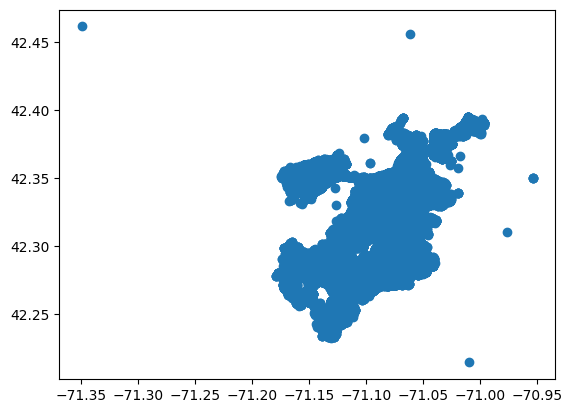

In [10]:
plt.scatter(x=crime_df["Long"], y=crime_df["Lat"])
plt.show()

In [11]:
boston_map = gpd.read_file("../data/boston.geojson")
boston_map.head()

,name,created_at,updated_at,cartodb_id,geometry
0,Roslindale,2013-02-19 04:40:34.216000+00:00,2013-02-19 04:40:34.466000+00:00,1,"MULTIPOLYGON (((-71.12593 42.27200, -71.12575 ..."
1,Jamaica Plain,2013-02-19 04:40:34.216000+00:00,2013-02-19 04:40:34.466000+00:00,2,"MULTIPOLYGON (((-71.09831 42.32630, -71.09858 ..."
2,Leather District,2013-02-19 04:40:34.216000+00:00,2013-02-19 04:40:34.466000+00:00,6,"MULTIPOLYGON (((-71.05838 42.34982, -71.05877 ..."
3,Roxbury,2013-02-19 04:40:34.216000+00:00,2013-02-19 04:40:34.466000+00:00,9,"MULTIPOLYGON (((-71.08314 42.34153, -71.08303 ..."
4,Fenway,2013-02-19 04:40:34.216000+00:00,2013-02-19 04:40:34.466000+00:00,17,"MULTIPOLYGON (((-71.11011 42.35207, -71.10986 ..."


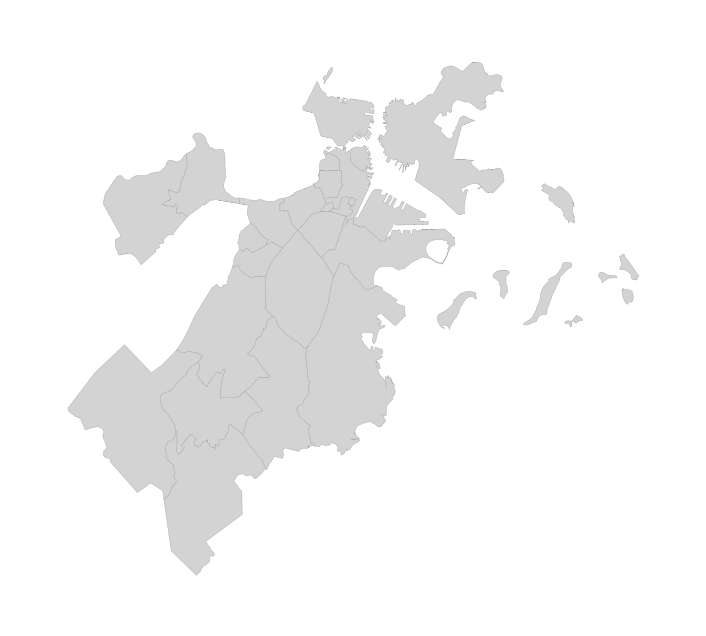

In [12]:
import geoplot
import geoplot.crs as gcrs

ax = geoplot.polyplot(
    boston_map,
    projection=gcrs.AlbersEqualArea(),
    edgecolor='darkgrey',
    facecolor='lightgrey',
    linewidth=.3,
    figsize=(12, 8)
)

# geoplot.pointplot(continental_usa_cities, ax=ax)
plt.show()


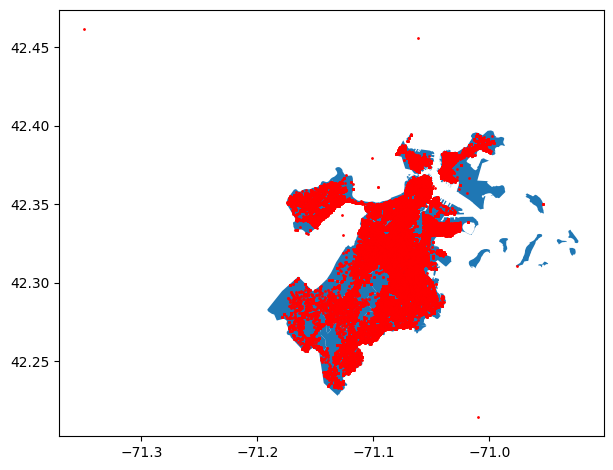

In [13]:
import folium

ax = boston_map.plot()
plt.scatter(x=crime_df["Long"], y=crime_df["Lat"], c='r', s=1)
plt.tight_layout()

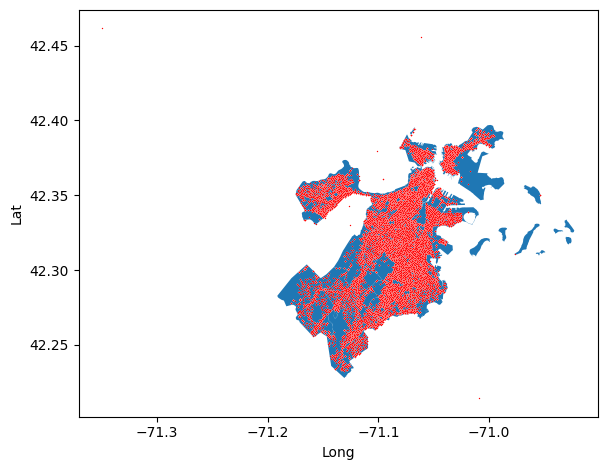

In [14]:
ax = boston_map.plot()
sns.scatterplot(data=crime_df, x="Long", y="Lat", c="r", s=1)
# plt.scatter(x=crime_df["Long"], y=crime_df["Lat"], c='r', s=1)
plt.tight_layout()

In [15]:
import plotly.express as px
import nbformat

df = px.data.gapminder().query("year==2007")
fig = px.scatter_geo(df, locations="iso_alpha", color="continent",
                     hover_name="country", size="pop",
                     projection="natural earth")
fig.show()